In [ ]:
# install libraries
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
# import libraries
import pandas as pd
import sqlite3
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# connect to database
conn = sqlite3.connect("/content/drive/MyDrive/Kaden/Projects/campaign_finance/campaign_donations.db")
cursor = conn.cursor()

In [ ]:
creating database

# connect to database
conn = sqlite3.connect("/content/drive/MyDrive/Kaden/Projects/campaign_finance/campaign_donations.db")
cursor = conn.cursor()

# define our fields
col_names = ["CMTE_ID", "AMNDT_IND", "RPT_TP", "TRANSACTION_PGI", "IMAGE_NUM", "TRANSACTION_TP", "ENTITY_TP",
             "NAME", "CITY", "STATE", "ZIP_CODE", "EMPLOYER", "OCCUPATION", "TRANSACTION_DT", "TRANSACTION_AMT",
             "OTHER_ID", "TRAN_ID", "FILE_NUM", "MEMO_CD", "MEMO_TEXT", "SUB_ID"]

# create tables if they don't exists
for i in range(1980, 2025, 4):
    cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS donations_{i}(
        CMTE_ID TEXT,
        AMNDT_IND TEXT,
        RPT_TP TEXT,
        TRANSACTION_PGI TEXT,
        IMAGE_NUM TEXT,
        TRANSACTION_TP TEXT,
        ENTITY_TP TEXT,
        NAME TEXT,
        CITY TEXT,
        STATE TEXT,
        ZIP_CODE TEXT,
        EMPLOYER TEXT,
        OCCUPATION TEXT,
        TRANSACTION_DT TEXT,
        TRANSACTION_AMT REAL,
        OTHER_ID TEXT,
        TRAN_ID TEXT,
        FILE_NUM TEXT,
        MEMO_CD TEXT,
        MEMO_TEXT TEXT,
        SUB_ID TEXT
    )
    """)
conn.commit()

# write data to tables
for i in range(1980, 2025, 4):
    for chunk in pd.read_csv(filepath_or_buffer=f"/content/drive/MyDrive/Kaden/Projects/campaign_finance/indiv{i}.txt", sep="|", names=col_names, chunksize=1000000, on_bad_lines="skip"):
        chunk.to_sql(f"donations_{i}", conn, if_exists='append', index=False)

# create indices on relevant columns to make querying efficient
for i in range(1980, 2025, 4):
    cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_transaction_tp ON donations_{i} (TRANSACTION_TP)")
    cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_name ON donations_{i} (NAME)")
    cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_transaction_amt ON donations_{i} (TRANSACTION_AMT)")

conn.commit()

In [ ]:
# adjust transaction amounts for inflation rate
inflation_rates = {1980 : 0.0313, 1984 : 0.0275, 1988 : 0.027, 1992 : 0.025, 1996 : 0.023, 2000 : 0.022,
                   2004 : 0.021, 2008 : 0.019, 2012 : 0.018, 2016 : 0.017, 2020 : 0.02, 2024 : 0}

In [ ]:
# distribution of total transaction amounts by individuals
dfs = []
for i in range(1980, 2025, 4):
    query = f"SELECT {i} AS year, SUM(TRANSACTION_AMT) * POWER(1 + {inflation_rates[i]}, 2024 - {i}) AS indiv_amt FROM donations_{i} GROUP BY NAME"
    df = pd.read_sql_query(query, conn)
    dfs.append(df)

In [ ]:
# concentration of donations by donor
def outlier_info(df, amount_donated):
    q1 = df["indiv_amt"].quantile(0.25)
    q3 = df["indiv_amt"].quantile(0.75)
    iqr = q3 - q1

    # examine huge outliers and add them to new dataset
    outliers = df.loc[(df["indiv_amt"] < q1 - 1.5 * iqr) | (df["indiv_amt"] > q3 + 1.5 * iqr)]
    outliers.sort_values(by = "indiv_amt", ascending = False)

    # what proportion of donation money do outliers make up
    outlier_proportion = outliers["indiv_amt"].sum() / amount_donated

    return outlier_proportion

In [ ]:
# get the proportion of donation shares by outlier donors for each year
outlier_proportions = {"year" : [], "outlier_proportion" : []}

for i in range(len(dfs)):
    outlier_proportion = outlier_info(dfs[i], dfs[i]["indiv_amt"].sum())
    outlier_proportions["year"].append(dfs[i]["year"].iloc[0])
    outlier_proportions["outlier_proportion"].append(outlier_proportion)

In [ ]:
# graph a lorenz curve to show the distribution of donation shares by donors
for df in dfs:
    df.reset_index(drop = True, inplace = True)
    df.sort_values(by = "indiv_amt", axis = 0, ascending = True, inplace = True)
    df["cum_sum"] = df["indiv_amt"].cumsum()
    df["cum_perc"] = df["cum_sum"] / df["indiv_amt"].sum() * 100
    df["percentile"] = (df.index + 1) / len(df) * 100

# merge dataframes
df = pd.concat(dfs, ignore_index=True)

# create Dash App
app = Dash(__name__)

# layout
app.layout = html.Div([
    html.H1("Cumulative Distribution of Donation Shares by Year"),
    dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': str(year), 'value': year} for year in sorted(df['year'].unique())],
        value=df['year'].min()
    ),
    dcc.Graph(id='lorenz-curve')
])

# callback to update histogram
@app.callback(
    Output('lorenz-curve', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_histogram(selected_year):
    filtered_df = df[df['year'] == selected_year]
    fig = px.line(filtered_df, x = 'percentile', y = "cum_perc",
                       title=f"Cumulative Distribution of Donation Shares in {selected_year}")
    fig.add_shape(type='line', x0=0, y0=0, x1=100, y1=100,
              line=dict(dash='dash', color='gray'))  # 45-degree equality line
    # fig.update_layout(bargap=0.1)
    return fig

# run the app in notebook
app.run_server(mode="inline")

<IPython.core.display.Javascript object>

In [ ]:
# calculate gini coefficients using trapezoidal riemann sums, in order to measure donations inequality
gini_coefficients = {"year" : [], "gini_coefficients" : []}
i = 1980
for df in dfs:
    area_under_curve = 0
    area_under_curve += np.trapz(df["cum_perc"], df["percentile"])
    gini_coefficient = (100 * 100 / 2 - area_under_curve) / (100 * 100 / 2)
    gini_coefficients["year"].append(i)
    gini_coefficients["gini_coefficients"].append(gini_coefficient)
    i += 4

print(gini_coefficients)

{'year': [1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024], 'gini_coefficients': [0.5684759402202726, 0.5382744654381221, 0.5045378125338208, 0.685244247554119, 0.7045462002803936, 0.7291812302968151, 0.6509985171427801, 0.6741667500073155, 0.7699327016505302, 0.8454960623014837, 0.8814270515813514, 0.8909458746453954]}


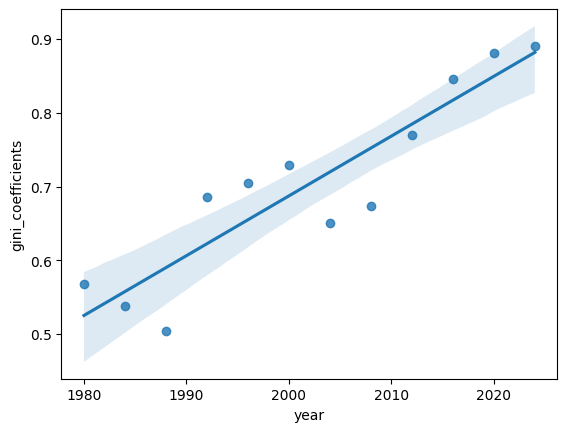

In [ ]:
# graph gini coefficients over time
gini_coefficients_df = pd.DataFrame(gini_coefficients)
sns.regplot(data = gini_coefficients_df, x = "year", y = "gini_coefficients")
plt.show()

In [ ]:
# 91% correlation between year and gini coefficents
gini_coefficients_df.corr()["gini_coefficients"]

,gini_coefficients
year,0.911431
gini_coefficients,1.000000


In [ ]:
gini_coefficients_df

,year,gini_coefficients
0,1980,0.568476
1,1984,0.538274
2,1988,0.504538
3,1992,0.685244
4,1996,0.704546
5,2000,0.729181
6,2004,0.650999
7,2008,0.674167
8,2012,0.769933
9,2016,0.845496


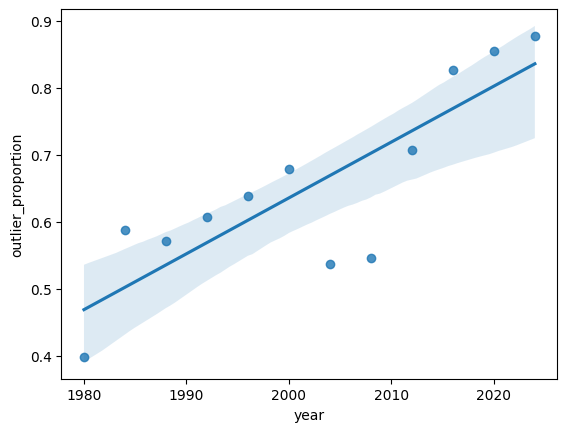

In [ ]:
# graph the proportion of donations contributed by outlier donors for each year
outlier_proportions_df = pd.DataFrame(outlier_proportions)
sns.regplot(data = outlier_proportions_df, x = "year", y = "outlier_proportion")
plt.show()

In [ ]:
# 83% correlation between year and proportion of donations contributed by outlier donors
outlier_proportions_df.corr()["outlier_proportion"]

,outlier_proportion
year,0.835545
outlier_proportion,1.000000


In [ ]:
# significant rise in gini coefficient between 1988 and 1992 election
print("Change in gini coefficient between 1988 and 1992" + str(gini_coefficients_df.iloc[3]["gini_coefficients"] - gini_coefficients_df.iloc[2]["gini_coefficients"]))

# 0.078 drop in gini coefficient and 0.14 drop in outlier donor shares between 2000 and 2004
print("Change in gini coefficient between 2000 and 2004: " +  str(gini_coefficients_df.iloc[6]["gini_coefficients"] - gini_coefficients_df.iloc[5]["gini_coefficients"]))
print("Change in proportion of donations from outlier donors between 2000 and 2004: " + str(outlier_proportions_df.iloc[6]["outlier_proportion"] - outlier_proportions_df.iloc[5]["outlier_proportion"]))

# drop can be linked to Bipartisan Campaign Reform Act of 2002, which required that money must be raised subject to FECA limits and raised limits on hard money contributions to decrease dependence on soft money

Change in gini coefficient between 2000 and 2004: -0.07818271315403502
Change in proportion of donations from outlier donors between 2000 and 2004: -0.14147237071301122
Change in gini coefficient between 2000 and 2004: 0.09576595164321466
Change in proportion of donations from outlier donors between 2000 and 2004: 0.16190748367017072


In [ ]:
# let's explore these changes in greater depth.

# 0.096 rise in gini coefficient and 0.16 rise in outlier donor shares between 2008 and 2012
print("Change in gini coefficient between 2000 and 2004: " +  str(gini_coefficients_df.iloc[8]["gini_coefficients"] - gini_coefficients_df.iloc[7]["gini_coefficients"]))
print("Change in proportion of donations from outlier donors between 2000 and 2004: " + str(outlier_proportions_df.iloc[8]["outlier_proportion"] - outlier_proportions_df.iloc[7]["outlier_proportion"]))

# rise can be linked to Citizens United v. FEC and SpeechNOW v. FEC cases of 2010, which established super pacs, independent expenditure organizations that can raise unlimited funds

In [ ]:
# concentration of donations by transaction type post 2010
transaction_type_dfs = []
for i in range(2012, 2025, 4):
    query = f"SELECT TRANSACTION_TP, COUNT(DISTINCT NAME) as donors, SUM(TRANSACTION_AMT) * POWER(1 + {inflation_rates[i]}, 2024 - {i}) AS indiv_amt FROM donations_{i} GROUP BY TRANSACTION_TP ORDER BY indiv_amt DESC"
    transaction_type_dfs.append(pd.read_sql_query(query, conn))

print(transaction_type_dfs[0])

   TRANSACTION_TP   donors     indiv_amt
0              15  1477384  3.531554e+09
1              10    24033  1.009161e+09
2             15C     1020  1.640755e+08
3             24T    56715  8.445667e+07
4             15E    51407  8.017425e+07
5             22Y    47818  6.599255e+07
6             24I     6618  2.419869e+07
7              11      777  1.895140e+07
8              19       67  9.143440e+06
9             20Y      166  2.955726e+06
10            21Y       42  2.226600e+05


In [ ]:
# calculate share of total donations by transaction type
for item in transaction_type_dfs:
    item["share"] = item["indiv_amt"] / item["indiv_amt"].sum()
display(transaction_type_dfs[0])

,TRANSACTION_TP,donors,indiv_amt,share,average donation value
0,15,1477384,3.531554e+09,0.707601,2390.410666
1,10,24033,1.009161e+09,0.202201,41990.619471
2,15C,1020,1.640755e+08,0.032875,160858.357360
3,24T,56715,8.445667e+07,0.016922,1489.141598
4,15E,51407,8.017425e+07,0.016064,1559.597968
5,22Y,47818,6.599255e+07,0.013223,1380.077615
6,24I,6618,2.419869e+07,0.004849,3656.496369
7,11,777,1.895140e+07,0.003797,24390.479007
8,19,67,9.143440e+06,0.001832,136469.249336
9,20Y,166,2.955726e+06,0.000592,17805.577862


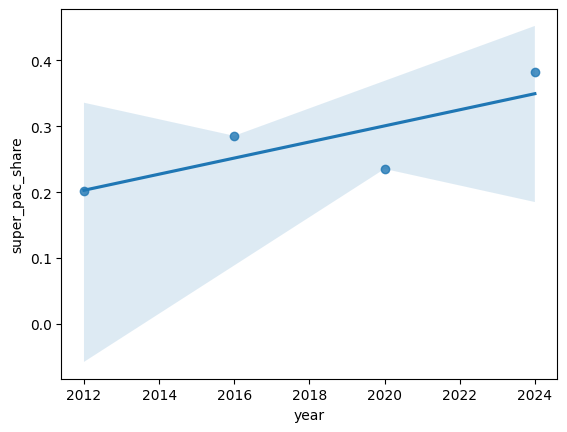

In [ ]:
# graph change in super pac shares over time
super_pac_shares = {"year" : [], "super_pac_share" : []}
i = 2012
for item in transaction_type_dfs:
    super_pac_shares["year"].append(i)
    super_pac_shares["super_pac_share"].append(item.loc[item["TRANSACTION_TP"] == "10"]["share"].iloc[0])
    i += 4

super_pac_shares_df = pd.DataFrame(super_pac_shares)
sns.regplot(data = super_pac_shares_df, x = "year", y = "super_pac_share")
plt.show()

In [ ]:
# correlation between year and super pac shares since inception of super pacs in 2010
super_pac_shares_df.corr()["super_pac_share"]

,super_pac_share
year,0.805675
super_pac_share,1.000000


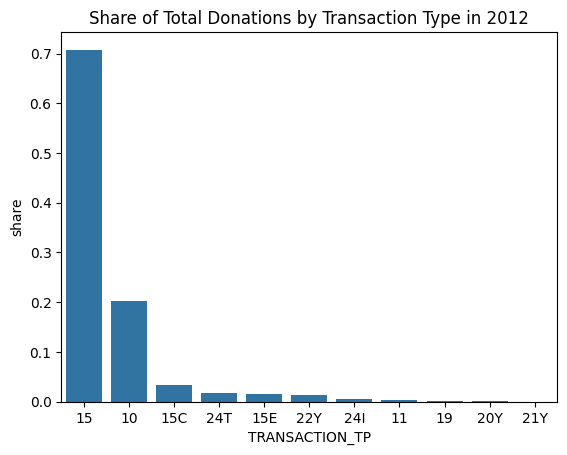

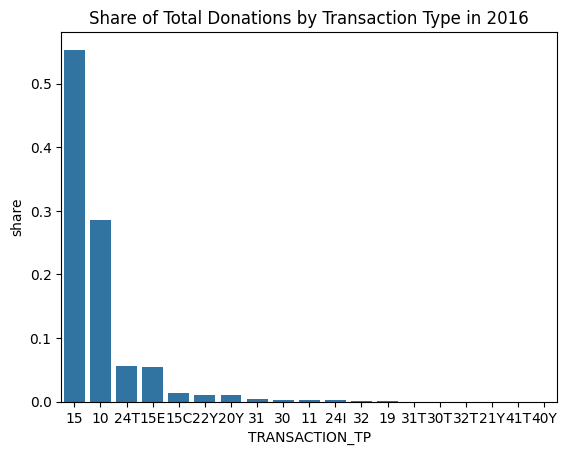

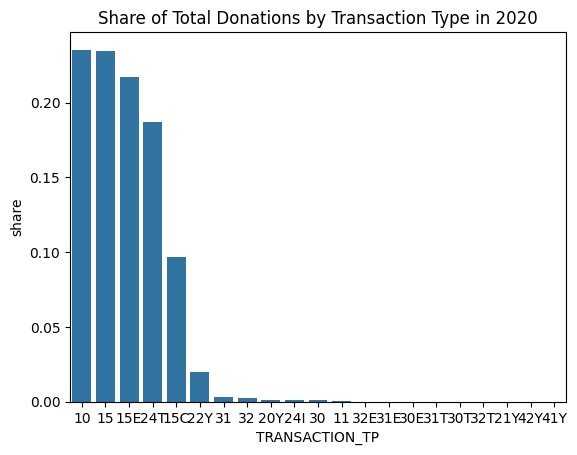

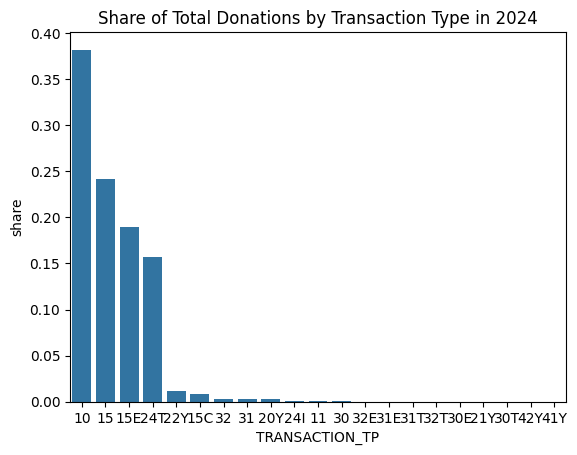

In [ ]:
# graph shares of transaction types over time
i = 2012
for item in transaction_type_dfs:
    sns.barplot(data = item, x = "TRANSACTION_TP", y = "share")
    plt.title(f"Share of Total Donations by Transaction Type in {i}")
    plt.show()
    i += 4

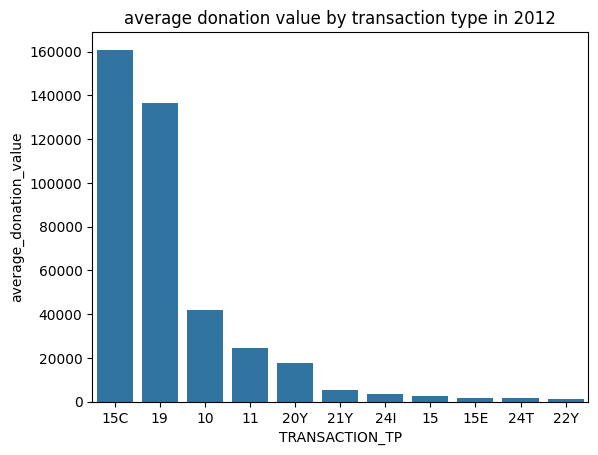

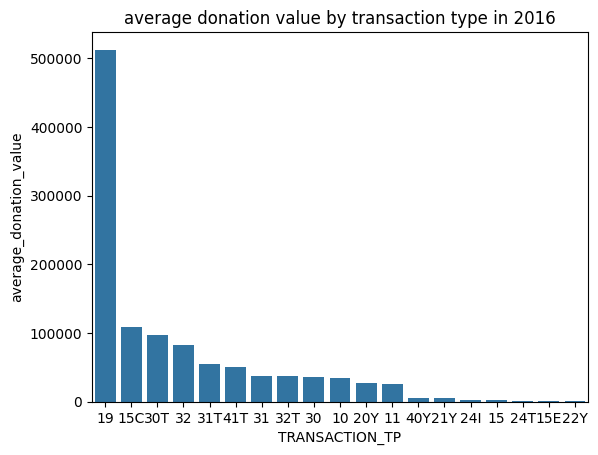

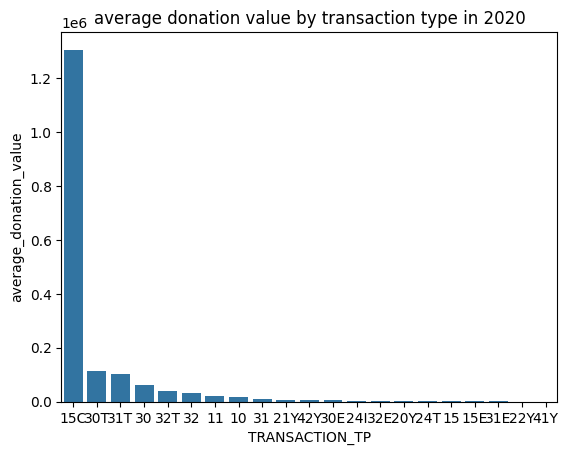

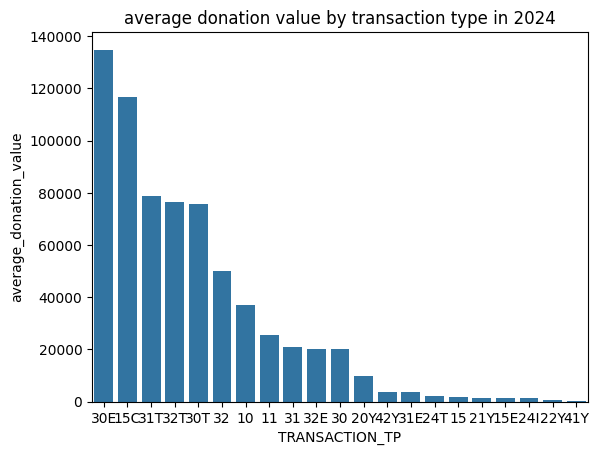

In [ ]:
# In 2016, super pacs overtook non independent expenditure only committees as the biggest recipients of total donations
# i.e. committees not directly linked with candidates are becoming more influential

# examine average donations by transaction type over time
i = 2012
for item in transaction_type_dfs:
    item["average_donation_value"] = item["indiv_amt"] / item["donors"]
    item.sort_values(by = "average_donation_value", ascending = False, inplace = True)
    sns.barplot(data = item, x = "TRANSACTION_TP", y = "average_donation_value")
    plt.title(f"average donation value by transaction type in {i}")
    plt.show()
    i += 4